In [56]:
import numpy as np
import csv
import time
import math
import pandas as pd
from numba import cuda, float32, float64
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
from numba import cuda
random.seed(1)

In [57]:
import findspark
findspark.init()
findspark.find()

'C:\\apps\\opt\\spark-3.0.3-bin-hadoop2.7'

In [58]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.appName("PySpark Application with califorina housing").getOrCreate()
print(spark.sparkContext.appName)

PySpark Application with califorina housing


In [59]:
def readData(file):
    file=open(file, 'r')
    reader=csv.reader(file)
    data= []
    for line in reader:
        data.append(line)
    data=np.array(data)
    return data

In [60]:
#Computes wT*x[i] ( the predicted value for datum)
def H(x,w,i):
    sum=0
    for j in range(len(x[0])):
        sum+=x[i][j]*w[j]
    return sum 

In [61]:
def forward_prop(x, weights):
    weights2=weights[n_inputs*n_hidden:]
    z3=0
    #Pass data from the initial layer to the hidden neurons
    for j in range(0,n_hidden-1):
        weights1=weights[n_inputs*j:n_inputs*(j+1)]
        result=0
        for k in range(0,n_inputs):
            result+=(x[k]*weights1[k])
            #result+=0.1
        #Activation function ReLu
        #result=max(0, result)
        #We can add what each hidden neuron contributes to the output layer
        z3+=result*weights2[j]
    #We add the bias
    z3+=weights2[n_hidden-1]
    return z3

In [62]:
#Function for calculating the error
def forward_propagation_Error(x,y,w):
    E=0
    for i in range(0, len(x)):
        wx=0
        wx=forward_prop(x[i], w)
        E+=((wx-y[i][0])**2)
    E=E/len(x)
    return E

In [63]:
class Particle:
    def __init__(self, position, initial_fitness):
         # particles position
        self.particle_position = position
        #initial value of the particle (infinity or minus infinity,
        #depending on whether we want to maximize or minimize)
        self.fitness_particle_position = initial_fitness
        # best position of the particle
        self.local_best_particle_position = []  
        #best initial value of the particle (infinity or minus infinity, 
        #depending on whether we want to maximize or minimize)
        self.fitness_local_best_particle_position = initial_fitness  
        # particle's velocity
        self.particle_velocity = []  
        for i in range(0,num_dimensions):
            #we generate the initial velocity randomly
            self.particle_velocity.append(random.uniform(-vMax, vMax))  
 
    def evaluate(self, x, y, mm):
        self.fitness_particle_position = forward_propagation_Error(x, y, self.particle_position)
        if mm == -1:
            if self.fitness_particle_position < self.fitness_local_best_particle_position:
                # We update the best local position
                self.local_best_particle_position = self.particle_position  
                # We update the best local value 
                self.fitness_local_best_particle_position = self.fitness_particle_position          
        if mm == 1:
            if self.fitness_particle_position > self.fitness_local_best_particle_position:
                 # We update the best local position
                self.local_best_particle_position = self.particle_position  
                # We update the best local value 
                self.fitness_local_best_particle_position = self.fitness_particle_position   
    def update_velocity(self, global_best_particle_position, w, Vmax, c1=2.8, c2=1.3):
        for i in range(0,num_dimensions):
            r1 = random.random()
            r2 = random.random()
            #We calculate the new velocity
            self.particle_velocity[i] = w * self.particle_velocity[i] + c1 * r1 * (self.local_best_particle_position[i] - self.particle_position[i]) + c2 * r2 * (global_best_particle_position[i] - self.particle_position[i])
            
            #We limit the maxmum velocity
            if(self.particle_velocity[i]>Vmax):
                self.particle_velocity[i]=Vmax
            if(self.particle_velocity[i]<-Vmax):
                self.particle_velocity[i]=-Vmax
 
    def update_position(self, bounds):
        for i in range(0,num_dimensions):
            self.particle_position[i] = self.particle_position[i] + self.particle_velocity[i]
 
            #if it reaches the edges, it stays within, it does not exceed the limits
            if self.particle_position[i] > bounds[1]:
                self.particle_position[i] = bounds[1]
            if self.particle_position[i] < bounds[0]:
                self.particle_position[i] = bounds[0]

In [64]:
from pyspark import SparkContext, SparkConf
#, SQLContext
conf = SparkConf().setAppName("projectName").setMaster("local[*]")
sc = SparkContext.getOrCreate(conf)
#sqlContext = SQLContext(sc)


In [65]:
#PS0 parameters
num_iters=900
num_particles=50
c1=1.0
c2=1.2
factor=10
Fi=c1+c2
Xi=2/(abs(2-Fi-math.sqrt(abs(Fi**2-4*Fi))))
data=readData('housing_Out.csv')
print('Data prior removing',data)
#We remove the first row of names and the last column
# data=data[1:500,27:33]
data=data[1:500,0:10]
print('Data after removing',data)
# We preprocess the data

rdd = sc.parallelize(data)

dataColl=rdd.collect()

print('RDD contents ', dataColl)

datosPandas=pd.DataFrame(rdd.collect(),columns=["number","longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"])

print('DF contents ',datosPandas)

#datosPandas.replace('?',np.NaN,inplace=True)

imp=SimpleImputer(missing_values=np.nan)

datos=imp.fit_transform(datosPandas)

np.random.shuffle(datos)
#Percentage of training (in this sample, 50%) and percentage of testing (25%)
p_train = 0.7
#Number of elements in the training and test datasets
len_train=int((len(datos))*p_train)
datos_train=datos[:len_train,:]
datos_test=datos[(len_train):,:]
#We separate the data "x" from the "y" (the data "y" is in the last column)
num_atrib=int(len(datos[0]))-1
x_train=datos_train[:,:num_atrib]
y_train=datos_train[:,num_atrib]
x_test=datos_test[:,:num_atrib]
y_test=datos_test[:,num_atrib]
datosPandas.head()
print('vector x_train ',x_train)
print('vector y_train ',y_train)

Data prior removing [['' 'longitude' 'latitude' ... 'median_income' 'median_house_value'
  'ocean_proximity']
 ['0' '-122.23' '37.88' ... '8.3252' '452600.0' 'NEAR BAY']
 ['1' '-122.22' '37.86' ... '8.3014' '358500.0' 'NEAR BAY']
 ...
 ['20637' '-121.22' '39.43' ... '1.7' '92300.0' 'INLAND']
 ['20638' '-121.32' '39.43' ... '1.8672' '84700.0' 'INLAND']
 ['20639' '-121.24' '39.37' ... '2.3886' '89400.0' 'INLAND']]
Data after removing [['0' '-122.23' '37.88' ... '126.0' '8.3252' '452600.0']
 ['1' '-122.22' '37.86' ... '1138.0' '8.3014' '358500.0']
 ['2' '-122.24' '37.85' ... '177.0' '7.2574' '352100.0']
 ...
 ['496' '-122.26' '37.85' ... '755.0' '3.2619' '309600.0']
 ['497' '-122.27' '37.85' ... '815.0' '2.7054' '182300.0']
 ['498' '-122.27' '37.85' ... '326.0' '2.2431' '172700.0']]
RDD contents  [array(['0', '-122.23', '37.88', '41.0', '880.0', '129.0', '322.0',
       '126.0', '8.3252', '452600.0'], dtype='<U18'), array(['1', '-122.22', '37.86', '21.0', '7099.0', '1106.0', '2401.0',
   

DF contents      number longitude latitude housing_median_age total_rooms total_bedrooms  \
0        0   -122.23    37.88               41.0       880.0          129.0   
1        1   -122.22    37.86               21.0      7099.0         1106.0   
2        2   -122.24    37.85               52.0      1467.0          190.0   
3        3   -122.25    37.85               52.0      1274.0          235.0   
4        4   -122.25    37.85               52.0      1627.0          280.0   
..     ...       ...      ...                ...         ...            ...   
494    494   -122.24    37.85               52.0      3726.0          474.0   
495    495   -122.25    37.86               52.0      4048.0          663.0   
496    496   -122.26    37.85               52.0      3618.0          768.0   
497    497   -122.27    37.85               52.0      4076.0          920.0   
498    498   -122.27    37.85               47.0      2077.0          400.0   

    population households median_incom

In [66]:
data = spark.sparkContext.parallelize(datos)
display(data.collect())
df= pd.DataFrame(data.collect())
# print(data)
#Data re-scaling
y_train=np.reshape(y_train, (-1,1))
y_train.reshape(-1,1)
y_test=np.reshape(y_test, (-1,1))
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
#
scaler_x.fit(x_train)
x_train=scaler_x.transform(x_train)
x_test=scaler_x.transform(x_test)
#
scaler_y.fit(y_train)
y_train=scaler_y.transform(y_train)
y_test=scaler_y.transform(y_test)
print('vector x_train scaled ',x_train)
print('vector y_train scaled',y_train)

[array([ 1.8900e+02, -1.2224e+02,  3.7790e+01,  4.7000e+01,  1.3720e+03,
         3.9500e+02,  1.2370e+03,  3.0300e+02,  2.1250e+00,  9.5500e+04]),
 array([ 2.8800e+02, -1.2217e+02,  3.7780e+01,  4.9000e+01,  8.9300e+02,
         1.7700e+02,  4.6800e+02,  1.8100e+02,  3.8750e+00,  1.4060e+05]),
 array([ 1.31000e+02, -1.22190e+02,  3.78400e+01,  1.80000e+01,
         1.61700e+03,  2.10000e+02,  5.33000e+02,  1.94000e+02,
         1.16017e+01,  3.92600e+05]),
 array([ 4.4400e+02, -1.2228e+02,  3.7870e+01,  4.9000e+01,  2.0260e+03,
         5.4800e+02,  9.6300e+02,  5.2100e+02,  1.9805e+00,  1.7370e+05]),
 array([ 1.5600e+02, -1.2224e+02,  3.7810e+01,  5.2000e+01,  2.4850e+03,
         3.1300e+02,  9.5300e+02,  3.2700e+02,  6.8591e+00,  3.5240e+05]),
 array([ 9.4000e+01, -1.2227e+02,  3.7800e+01,  3.9000e+01,  1.7150e+03,
         6.2300e+02,  1.3270e+03,  4.6700e+02,  1.8477e+00,  1.7920e+05]),
 array([ 5.9000e+01, -1.2229e+02,  3.7820e+01,  2.0000e+00,  1.5800e+02,
         4.3000e+01, 

vector x_train scaled  [[0.37903226 0.45454545 0.35294118 ... 0.24541977 0.15102041 0.14638167]
 [0.57862903 0.77272727 0.29411765 ... 0.09059795 0.08877551 0.30401376]
 [0.26209677 0.68181818 0.64705882 ... 0.10368432 0.09540816 1.        ]
 ...
 [0.6391129  0.68181818 0.17647059 ... 0.22669619 0.1755102  0.02417626]
 [0.94354839 0.22727273 0.82352941 ... 0.15582847 0.16020408 0.18241186]
 [0.22983871 0.40909091 0.58823529 ... 0.10388565 0.14489796 0.2380695 ]]
vector y_train scaled [[0.08068163]
 [0.1831814 ]
 [0.75590737]
 [0.2584085 ]
 [0.66454394]
 [0.27090848]
 [0.        ]
 [0.3443174 ]
 [0.04613626]
 [0.06249986]
 [0.52158972]
 [0.72022564]
 [0.40818089]
 [0.04704535]
 [0.41227179]
 [0.11659064]
 [0.12249972]
 [0.16499963]
 [0.26704485]
 [0.90067977]
 [0.46227168]
 [0.28977207]
 [0.41318088]
 [0.27795391]
 [0.34545376]
 [0.16204509]
 [0.21068134]
 [0.22204495]
 [0.43818082]
 [0.0997725 ]
 [0.12454517]
 [0.22886312]
 [0.2854539 ]
 [0.15795419]
 [0.03409083]
 [0.47658983]
 [0.072

In [67]:
#Neural network parameters (as function of the input)
n_inputs=x_train[0].size
n_hidden=math.floor(len(x_train)/(factor*(n_inputs+1)))+1
#We calculate the number of weights necessary to carry out the computation
num_weights=(n_inputs*n_hidden)+n_hidden
bound0=float(max(y_train))#upper limit
bound1=-bound0 #lower limit
vMax=bound0*0.6
weights=[]
for i in range(0,num_particles):
        for j in range(0, num_weights):
            weights.append(random.uniform(-1, 1))
print('total number of weights ', len(weights))
#print('Initial weights values', weights )

total number of weights  2000


In [68]:
class Neural_Network:
    # the parameters are the data, the number of neurons of the input layer, 
    # the number of neurons of the hidden layer and 
    # the number of neurons of the output layer
    def __init__(self, x, y, n_inputs, n_hidden, weights, num_weights):
        self.input=x
        self.y=y
        
        self.weights=weights
        self.num_weights=num_weights
        
    def train_PSO(self):
        best_position, fitness=PSO_Neural_Network(self.input, self.y,self.weights, self.num_weights,[bound1,bound0], -1, num_particles, 100, 0.9, 0.1, vMax)
        self.weights=best_position
        return fitness
    
    def predict(self, x_test):
        return forward_prop(x_test, self.weights)    

In [69]:
#PSO parallel
@cuda.jit
#def PSO_GPU(x, y):
def PSO_GPU(x, y, particle_positions, particle_velocity, personal_best_particle_position,fitness_personal_best_particle_position, local_best_particle_position, fitness_local_best_particle_position,pool, c1, c2, Vmax, bound0, bound1):
  
    particle= cuda.blockIdx.x #We found the particle that corresponds to the block where the thread is
    nx=cuda.threadIdx.x #Finds the neurons of the hidden layer that this thread is going to calculate 
    #in this thread. Thread '0' does the rest of the particle calculations
   
    #We initialize the vectors in a shared-memory array (common to the block == to the particle)
    z2=cuda.shared.array(shape=n_hidden, dtype=float32)

    for iters in range(0, num_iters):
        #We take particle's position corresponding to the thread
        position=particle_positions[num_weights*particle: num_weights*(particle+1)]

        #We do forward propagation
        fitness_position=0
        weights2=position[n_inputs*n_hidden:]
        for i in range(0, len(x)):
            j=nx
            while(j<n_hidden):
                #Pass from the init layer to the hidden layer
                hidden_result=0
                weights1=position[n_inputs*j:n_inputs*(j+1)]
                for k in range(0,n_inputs-1):
                    hidden_result+=(x[i][k]*weights1[k])
                hidden_result+=weights1[n_inputs-1] #We add the bias
                #Function ReLu (activation of)
                hidden_result=max(0, hidden_result)
                #We save the value in the vector z2, to add it when the total value 
                #is calculated in the output layer
                z2[j]=hidden_result*weights2[j]
                j=j+threadsperblock
   
            # Thread synchronization
            cuda.syncthreads()
           
            #Thread '0' gathers the results of other threads
            if(nx==0):
                result=0
                for h in range (0, n_hidden):
                    result+=z2[h]
                fitness_position+=float((y[i][0]-result)**2)
            # Thread synchronization
            cuda.syncthreads()
            
        if(nx==0):
            #We update the best personal position
            fitness_position=fitness_position/len(x)
            if fitness_position < fitness_personal_best_particle_position[particle]:
                for i in range(0, num_weights):
                    personal_best_particle_position[(num_weights*particle)+i] = particle_positions[num_weights*particle+i]  # we update the best personal position
                # we update the best personal value
                fitness_personal_best_particle_position[particle] = fitness_position 
       
        # We synchronize the threads
        cuda.syncthreads()
       
        if(nx==0):
            #Best local position updating
            if fitness_personal_best_particle_position[particle]< fitness_local_best_particle_position[particle]:
                for i in range(0, num_weights):
                    local_best_particle_position[num_weights*particle+i] = personal_best_particle_position[(num_weights*particle)+i]
                fitness_local_best_particle_position[particle] = fitness_personal_best_particle_position[particle]
           
            if fitness_personal_best_particle_position[int(math.fmod((num_particles+particle-1), num_particles))] < fitness_local_best_particle_position[particle]:
                for i in range(0, num_weights):
                    local_best_particle_position[num_weights*(particle)+i] = particle_positions[num_weights*(int(math.fmod((num_particles+particle-1), num_particles)))+i]
                fitness_local_best_particle_position[particle] = fitness_personal_best_particle_position[int(math.fmod((num_particles+particle-1), num_particles))]
           
               
            if fitness_personal_best_particle_position[int(math.fmod((num_particles+particle+1), num_particles))] < fitness_local_best_particle_position[particle]:
                for i in range(0, num_weights):
                    local_best_particle_position[num_weights*(particle)+i] = particle_positions[num_weights*(int(math.fmod((num_particles+particle+1), num_particles)))+i]
                fitness_local_best_particle_position[particle] = fitness_personal_best_particle_position[int(math.fmod((num_particles+particle+1), num_particles))]
           
        # Thread synchronization
        cuda.syncthreads()
        
        #We choose numbers from the random numbers repository
        r1=pool[2*num_weights*num_particles+particle+iters]
        r2=pool[2*num_weights*num_particles-particle-iters]
       
        i=nx
        #We update each particle's velocity
        while i<num_weights:
            #We calculate the new velocity
            particle_velocity[num_weights*particle+i] = Xi*( particle_velocity[num_weights*particle+i] + c1 * r1 * (personal_best_particle_position[num_weights*particle+i] - particle_positions[num_weights*particle+i]) + c2 * r2 * (local_best_particle_position[num_weights*particle+i] - particle_positions[num_weights*particle+i]))
            #We limit speed to maximum speed
            if particle_velocity[num_weights*particle+i]>Vmax :
                particle_velocity[num_weights*particle+i]=Vmax
            if particle_velocity[num_weights*particle+i]<(Vmax*(-1)):
                particle_velocity[num_weights*particle+i]=(Vmax*(-1))
            i+=threadsperblock
       
        # Wait until all threads finish computing
        cuda.syncthreads()      
        i=nx
        #We update each particle's position
        while i<num_weights:
            particle_positions[num_weights*particle+i] = particle_positions[num_weights*particle+i] + particle_velocity[num_weights*particle+i]
            #if it reaches and edge, it stays in there, it does not trespasses it
            if particle_positions[num_weights*particle+i] > bound0:
                particle_positions[num_weights*particle+i] = bound0
            if particle_positions[num_weights*particle+i] < bound1:
                particle_positions[num_weights*particle+i] = bound1
            i+=threadsperblock
           
        # Wait until all threads finish computing
        cuda.syncthreads()  

In [70]:
def coresPerSM():
    cc_cores_per_SM_dict = {
    (2,0) : 32,
    (2,1) : 48,
    (3,0) : 192,
    (3,5) : 192,
    (3,7) : 192,
    (5,0) : 128,
    (5,2) : 128,
    (6,0) : 64,
    (6,1) : 128,
    (7,0) : 64,
    (7,5) : 64,
    (8,0) : 64,
    (8,6) : 128
    }
    # the above dictionary should result in a value of "None" if a cc match 
    # is not found.  The dictionary needs to be extended as new devices become
    # available, and currently does not account for all Jetson devices
    device = cuda.get_current_device()
    #my_cc = getattr(device, 'COMPUTE_CAPABILITY')
    my_cc=(6,1)
    cores_per_sm = cc_cores_per_SM_dict.get(my_cc)
    return cores_per_sm
device = cuda.get_current_device()
threadsperblock =  coresPerSM()
blockspergrid=num_particles
print('device, num weights, threads per block, blocks, c1, c2, vMax, bound0, bound1 ->',getattr(device, 'MULTIPROCESSOR_COUNT'),num_weights,threadsperblock,blockspergrid,c1, c2, vMax, bound0, bound1)

device, num weights, threads per block, blocks, c1, c2, vMax, bound0, bound1 -> 3 40 128 50 1.0 1.2 0.6 1.0 -1.0


In [71]:
#We generate one pool of random numbers and initial data
pool=[]
fitness_personal_best_particle_position=[]
fitness_local_best_particle_position=[]
for i in range(0,num_particles):
        for j in range(0, num_weights*3):
            pool.append(random.uniform(bound1, bound0))
        fitness_local_best_particle_position.append(float("inf"))
        fitness_personal_best_particle_position.append(float("inf"))
#We load data to the gpu
x_global_mem=cuda.to_device(np.ascontiguousarray(x_train))
y_global_mem=cuda.to_device(np.ascontiguousarray(y_train))
fitness_personal_best_particle_position_global_mem=cuda.to_device(np.asarray(fitness_personal_best_particle_position))
personal_best_particle_position=cuda.to_device(np.zeros(num_weights*num_particles))
local_best_particle_position=cuda.to_device(np.zeros(num_weights*num_particles))
fitness_local_best_particle_position_global_mem=cuda.to_device(np.ascontiguousarray(fitness_local_best_particle_position))
pool_global_mem=cuda.to_device(np.ascontiguousarray(pool))

#We initiate positions and velocities of particles by taking data from the pool of random numbers
particles_positions=pool_global_mem[0:num_weights*num_particles]
particles_velocity=pool_global_mem[num_weights*num_particles:2*num_weights*num_particles]
print("Data loaded in GPU correctly!")

Data loaded in GPU correctly!


In [72]:
from numba import cuda
gpu = cuda.get_current_device()
print("name = %s" % gpu.name)
print("maxThreadsPerBlock = %s" % str(gpu.MAX_THREADS_PER_BLOCK))
print("maxBlockDimX = %s" % str(gpu.MAX_BLOCK_DIM_X))
print("maxBlockDimY = %s" % str(gpu.MAX_BLOCK_DIM_Y))
print("maxBlockDimZ = %s" % str(gpu.MAX_BLOCK_DIM_Z))
print("maxGridDimX = %s" % str(gpu.MAX_GRID_DIM_X))
print("maxGridDimY = %s" % str(gpu.MAX_GRID_DIM_Y))
print("maxGridDimZ = %s" % str(gpu.MAX_GRID_DIM_Z))
print("maxSharedMemoryPerBlock = %s" % 
str(gpu.MAX_SHARED_MEMORY_PER_BLOCK))
print("asyncEngineCount = %s" % str(gpu.ASYNC_ENGINE_COUNT))
print("canMapHostMemory = %s" % str(gpu.CAN_MAP_HOST_MEMORY))
print("multiProcessorCount = %s" % str(gpu.MULTIPROCESSOR_COUNT))
print("warpSize = %s" % str(gpu.WARP_SIZE))
print("unifiedAddressing = %s" % str(gpu.UNIFIED_ADDRESSING))
print("pciBusID = %s" % str(gpu.PCI_BUS_ID))
print("pciDeviceID = %s" % str(gpu.PCI_DEVICE_ID))

name = b'NVIDIA GeForce 940MX'
maxThreadsPerBlock = 1024
maxBlockDimX = 1024
maxBlockDimY = 1024
maxBlockDimZ = 64
maxGridDimX = 2147483647
maxGridDimY = 65535
maxGridDimZ = 65535
maxSharedMemoryPerBlock = 49152
asyncEngineCount = 4
canMapHostMemory = 1
multiProcessorCount = 3
warpSize = 32
unifiedAddressing = 1
pciBusID = 1
pciDeviceID = 0


In [73]:
#And now it's time to launch the computation in parallel!!!!
start = time.time()
cuda.profile_start()

PSO_GPU[blockspergrid, threadsperblock](x_global_mem, y_global_mem,particles_positions, particles_velocity, personal_best_particle_position,fitness_personal_best_particle_position_global_mem, local_best_particle_position,fitness_local_best_particle_position_global_mem, pool_global_mem,c1, c2, vMax, bound0, bound1)

local_best_particle_position_host=local_best_particle_position.copy_to_host()
fitness_local_best_particle_position=fitness_local_best_particle_position_global_mem.copy_to_host()
cuda.profile_stop()
end = time.time()
time=end - start
print("Execution time(s): ", time)

Execution time(s):  4.96856164932251


In [74]:
import time
global_best_particle_position=[]
fitness_global_best_particle_position=float("inf")
for i in range(0, num_particles):
    if(fitness_local_best_particle_position[i]<fitness_global_best_particle_position):
        global_best_particle_position=local_best_particle_position_host[num_weights*i:num_weights*(i+1)]
        fitness_global_best_particle_position=fitness_local_best_particle_position[i]

#We calculate the transfer time between the host (CPU) and the device (GPU), and we remove it from the calculation
start2 = time.time()
local_best_particle_position_host=local_best_particle_position.copy_to_host()
fitness_local_best_particle_position=fitness_local_best_particle_position_global_mem.copy_to_host()
end2 = time.time()
time_corr=end - start -(end2-start2)
#Error calculation
Eout=0
Error_Cero=0
prediction=np.zeros(len(x_test))
for i in range(0, len(x_test)):
        prediction[i]=forward_prop(x_test[i], global_best_particle_position)
        # mean standard error (MSE), for regression problems
        Eout+=float((y_test[i][0]-prediction[i]))**2
Eout=Eout/len(x_test)
#results
print("Number of iterations of PSO =", num_iters)
print("Running time(s): ", time_corr)
print('Ein:', fitness_global_best_particle_position)
print('Eout:', Eout)

Number of iterations of PSO = 900
Running time(s):  4.966012477874756
Ein: 0.018689598259142192
Eout: 0.3332448445606629


In [75]:
# prediction=np.zeros(len(x_test))
red_neuronal=Neural_Network(x_train, y_train, n_inputs, n_hidden, weights, num_weights)

# red_neuronal.fit(x_train,y_train)
pred_results = []

for i in range(len(x_test)):
    y_pred=red_neuronal.predict(x_test[i])
    y_pred=(1/len(x_test))*((y_pred-y_test[i])**2)
    pred_results.append(y_pred)
np.hstack(pred_results)
pred_results = np.array(pred_results, dtype=np.float32)
maxValue_pred_results = np.max(pred_results)
minValue_pred_results = np.min(pred_results)
median_pred_results = np.median(pred_results)
median_y_test = np.median(y_test)
maxValue_y_test = np.max(y_test)
minValue_y_test = np.min(y_test)
print('median_pred_results: ', median_pred_results)
print('max_pred_results: ', maxValue_pred_results)
print('min_pred_results: ',minValue_pred_results)
print('median_y_test: ', median_y_test)
print('max_y_test: ',maxValue_y_test)
print('min_y_test: ',minValue_y_test)
print('pred_results: \n', pred_results)

median_pred_results:  0.009933607
max_pred_results:  0.043111518
min_pred_results:  0.0034310538
median_y_test:  0.23624946306940214
max_y_test:  1.0
min_y_test:  0.025681759814182248
pred_results: 
 [[0.01777875]
 [0.02650036]
 [0.00661519]
 [0.00617438]
 [0.00631042]
 [0.01107646]
 [0.00615924]
 [0.00988801]
 [0.00511287]
 [0.02816846]
 [0.00589138]
 [0.02077758]
 [0.01325753]
 [0.00664697]
 [0.00651288]
 [0.00495886]
 [0.0073549 ]
 [0.02102842]
 [0.0147224 ]
 [0.00612622]
 [0.00741719]
 [0.01608223]
 [0.00833335]
 [0.00474073]
 [0.01923639]
 [0.0130271 ]
 [0.00918729]
 [0.01668087]
 [0.0131094 ]
 [0.01933174]
 [0.00566657]
 [0.01276954]
 [0.0088633 ]
 [0.00614784]
 [0.01430895]
 [0.01034536]
 [0.00548321]
 [0.00643252]
 [0.0061257 ]
 [0.01630503]
 [0.01419263]
 [0.01125323]
 [0.00655582]
 [0.00715989]
 [0.0099792 ]
 [0.00742544]
 [0.02603462]
 [0.01980464]
 [0.0270703 ]
 [0.00816032]
 [0.02156015]
 [0.02139807]
 [0.02432517]
 [0.01761539]
 [0.02626443]
 [0.00619847]
 [0.00695329]
 [

In [76]:
threshold_predict = 0.01                       # decide on a cutoff limit
y_pred_classes = np.zeros_like(pred_results)    # initialise a matrix full with zeros
y_pred_classes[pred_results > threshold_predict] = 1  
threshold_y_test = 0.2
# add a 1 if the cutoff was breached
y_test_classes = np.zeros_like(y_test)
y_test_classes[y_test > threshold_y_test] = 1
print('y_pred_classes: \n ',y_pred_classes.shape)
print('y_test_classes: \n',y_test_classes.shape)
print('y_pred_classes: \n ',y_pred_classes)
print('y_test: \n',y_test_classes)

y_pred_classes: 
  (150, 1)
y_test_classes: 
 (150, 1)
y_pred_classes: 
  [[1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]]
y_test: 
 [[1.]
 [1.]
 [0

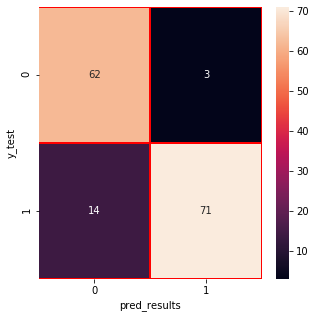

Confusion matrix: 
 [[62  3]
 [14 71]]


In [77]:
from sklearn.metrics import  confusion_matrix, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
mean_squared_error(y_test_classes,pred_results)
import seaborn as sns
import matplotlib.pyplot as plt
f, ax=plt.subplots(figsize=(5,5))
cm=confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("pred_results")
plt.ylabel("y_test")
plt.show()
print('Confusion matrix: \n',cm)

In [78]:
from sklearn.metrics import classification_report
print('Classification report: \n',classification_report(y_test_classes, y_pred_classes))
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_test_classes, y_pred_classes)
auc_roc
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_classes, y_pred_classes)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('roc_auc: ', roc_auc)
thresholds

Classification report: 
               precision    recall  f1-score   support

         0.0       0.82      0.95      0.88        65
         1.0       0.96      0.84      0.89        85

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.90      0.89      0.89       150

roc_auc:  0.8945701357466064


array([2., 1., 0.], dtype=float32)

Text(0.5, 0, 'False Positive Rate')

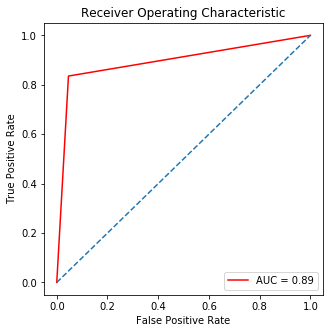

In [79]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [80]:
import matplotlib.pyplot as plt

# prediccionClasification=np.zeros(len(y_test_classes))
thresholds=[]
accuracy=[]
precision=[]
recall=[]
f1=[]

# predictionClasification=np.zeros(len(y_test_classes))
for i in range(0, len(y_pred_classes)):
    accuracy.append(accuracy_score(y_test_classes, y_pred_classes))
    precision.append(precision_score(y_test_classes, y_pred_classes))
    recall.append(recall_score(y_test_classes, y_pred_classes))
    f1.append(f1_score(y_test_classes, y_pred_classes))
print('accuracy_score: ', accuracy_score(y_test_classes, y_pred_classes))
print('precision_score: ', precision_score(y_test_classes, y_pred_classes))
print('recall_score: ', recall_score(y_test_classes, y_pred_classes))
print('f1_score: ', f1_score(y_test_classes, y_pred_classes))

accuracy_score:  0.8866666666666667
precision_score:  0.9594594594594594
recall_score:  0.8352941176470589
f1_score:  0.8930817610062894


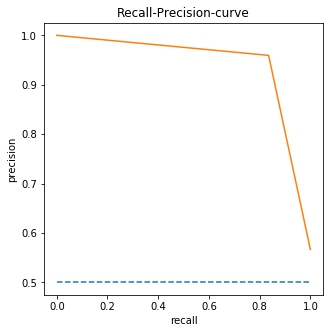

In [81]:
from sklearn.metrics import auc, precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test_classes, y_pred_classes)
#create precision-recall curve

plt.figure(figsize = (5,5))
plt.plot([0, 1], [0.5, 0.5],'--')
plt.plot(recall, precision, label = 'Precision')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Recall-Precision-curve')
plt.show()

In [82]:
from sklearn.metrics import f1_score, r2_score
f1= f1_score(y_test_classes, y_pred_classes)
print("MSE: ",mean_squared_error(y_test_classes,y_pred_classes))
print('F1-score: ', f1)

MSE:  0.11333333333333333
F1-score:  0.8930817610062894
